In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse

In [2]:
#create df of preprocessed data - game data from 2004-2024
df = pd.read_csv('nbaDatabasePreProcessed2004-2024-allPost (1).csv')
df

,date,homeTeam,homeTeam_id,homeTeam_win%,homeTeam_wins,homeTeam_losses,homeTeam_points_total,homeTeam_points_q1,homeTeam_points_q2,homeTeam_points_q3,...,awayTeam_D_Reb,awayTeam_Total_Reb,awayTeam_Ast,awayTeam_Stl,awayTeam_Blk,awayTeam_TO,awayTeam_PF,winner,season,isPlayoffGame
0,2024-06-17,Boston Celtics,BOS,0.792079,80,21,106,28,39,19,...,28,35,18,4,4,13,20,Boston Celtics,2023-2024,True
1,2024-06-14,Dallas Mavericks,DAL,0.611650,63,40,122,34,27,31,...,27,31,18,2,5,13,19,Dallas Mavericks,2023-2024,True
2,2024-06-12,Dallas Mavericks,DAL,0.607843,62,40,99,31,20,19,...,30,36,26,4,6,9,19,Boston Celtics,2023-2024,True
3,2024-06-09,Boston Celtics,BOS,0.795918,78,20,105,25,29,29,...,34,43,21,5,3,15,17,Boston Celtics,2023-2024,True
4,2024-06-06,Boston Celtics,BOS,0.793814,77,20,107,37,26,23,...,33,43,9,8,1,11,16,Boston Celtics,2023-2024,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25726,2004-11-03,Cleveland Cavaliers,CLE,0.000000,0,1,104,21,19,27,...,36,47,24,9,5,13,28,Indiana Pacers,2004-2005,False
25727,2004-11-03,Boston Celtics,BOS,0.000000,0,1,95,22,31,30,...,27,41,20,9,2,16,26,Philadelphia 76ers,2004-2005,False
25728,2004-11-02,Los Angeles Lakers,LAL,1.000000,1,0,89,24,26,22,...,32,48,17,10,8,16,21,Los Angeles Lakers,2004-2005,False
25729,2004-11-02,Detroit Pistons,DET,1.000000,1,0,87,19,18,22,...,27,36,8,4,5,16,24,Detroit Pistons,2004-2005,False


In [3]:
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

In [4]:
#maps franchises to subjectID
subjectID_dict = {
    "ATL": 1,
    "BOS": 2,
    "BKN": 3,
    "CHA": 4,
    "CHI": 5,
    "CLE": 6,
    "DAL": 7,
    "DEN": 8,
    "DET": 9,
    "GSW": 10,
    "HOU": 11,
    "IND": 12,
    "LAC": 13,
    "LAL": 14,
    "MEM": 15,
    "MIA": 16,
    "MIL": 17,
    "MIN": 18,
    "NOP": 19,
    "NYK": 20,
    "OKC": 21,
    "ORL": 22,
    "PHI": 23,
    "PHX": 24,
    "POR": 25,
    "SAC": 26,
    "SAS": 27,
    "TOR": 28,
    "UTA": 29,
    "WAS": 30,
    "NOH": 19, #New Orleans Hornets is same franchise as NOP- New Orleans Pelicans
    "NJN": 3, #New Jersey Nets relocated to Brooklyn
    "SEA": 21, #Seattle Supersonics Relocated to OKC
    "NOK": 19, #New Orleans Hornets relocated to OKC 2005-2007 - Eventually became New Orleans Pelicans
    
}

In [5]:
#map the subject IDs to a number to handle franchise moves
df["homeTeamSubject_id"] = df["homeTeam_id"].map(subjectID_dict)
df["awayTeamSubject_id"] = df["awayTeam_id"].map(subjectID_dict)

cols = df.columns.tolist()
cols.insert(cols.index("homeTeam_id") + 1, cols.pop(cols.index("homeTeamSubject_id")))
cols.insert(cols.index("awayTeam_id") + 1, cols.pop(cols.index("awayTeamSubject_id")))
df = df[cols]

df

,date,homeTeam,homeTeam_id,homeTeamSubject_id,homeTeam_win%,homeTeam_wins,homeTeam_losses,homeTeam_points_total,homeTeam_points_q1,homeTeam_points_q2,...,awayTeam_D_Reb,awayTeam_Total_Reb,awayTeam_Ast,awayTeam_Stl,awayTeam_Blk,awayTeam_TO,awayTeam_PF,winner,season,isPlayoffGame
0,2024-06-17,Boston Celtics,BOS,2,0.792079,80,21,106,28,39,...,28,35,18,4,4,13,20,Boston Celtics,2023-2024,True
1,2024-06-14,Dallas Mavericks,DAL,7,0.611650,63,40,122,34,27,...,27,31,18,2,5,13,19,Dallas Mavericks,2023-2024,True
2,2024-06-12,Dallas Mavericks,DAL,7,0.607843,62,40,99,31,20,...,30,36,26,4,6,9,19,Boston Celtics,2023-2024,True
3,2024-06-09,Boston Celtics,BOS,2,0.795918,78,20,105,25,29,...,34,43,21,5,3,15,17,Boston Celtics,2023-2024,True
4,2024-06-06,Boston Celtics,BOS,2,0.793814,77,20,107,37,26,...,33,43,9,8,1,11,16,Boston Celtics,2023-2024,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25726,2004-11-03,Cleveland Cavaliers,CLE,6,0.000000,0,1,104,21,19,...,36,47,24,9,5,13,28,Indiana Pacers,2004-2005,False
25727,2004-11-03,Boston Celtics,BOS,2,0.000000,0,1,95,22,31,...,27,41,20,9,2,16,26,Philadelphia 76ers,2004-2005,False
25728,2004-11-02,Los Angeles Lakers,LAL,14,1.000000,1,0,89,24,26,...,32,48,17,10,8,16,21,Los Angeles Lakers,2004-2005,False
25729,2004-11-02,Detroit Pistons,DET,9,1.000000,1,0,87,19,18,...,27,36,8,4,5,16,24,Detroit Pistons,2004-2005,False


In [6]:
#generate a binary winner column
df['winner_binary'] = (df['winner'] == df['awayTeam']).astype(int)
df

C:\Users\Max Braithwaite\AppData\Local\Temp\ipykernel_28584\767967889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['winner_binary'] = (df['winner'] == df['awayTeam']).astype(int)


,date,homeTeam,homeTeam_id,homeTeamSubject_id,homeTeam_win%,homeTeam_wins,homeTeam_losses,homeTeam_points_total,homeTeam_points_q1,homeTeam_points_q2,...,awayTeam_Total_Reb,awayTeam_Ast,awayTeam_Stl,awayTeam_Blk,awayTeam_TO,awayTeam_PF,winner,season,isPlayoffGame,winner_binary
0,2024-06-17,Boston Celtics,BOS,2,0.792079,80,21,106,28,39,...,35,18,4,4,13,20,Boston Celtics,2023-2024,True,0
1,2024-06-14,Dallas Mavericks,DAL,7,0.611650,63,40,122,34,27,...,31,18,2,5,13,19,Dallas Mavericks,2023-2024,True,0
2,2024-06-12,Dallas Mavericks,DAL,7,0.607843,62,40,99,31,20,...,36,26,4,6,9,19,Boston Celtics,2023-2024,True,1
3,2024-06-09,Boston Celtics,BOS,2,0.795918,78,20,105,25,29,...,43,21,5,3,15,17,Boston Celtics,2023-2024,True,0
4,2024-06-06,Boston Celtics,BOS,2,0.793814,77,20,107,37,26,...,43,9,8,1,11,16,Boston Celtics,2023-2024,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25726,2004-11-03,Cleveland Cavaliers,CLE,6,0.000000,0,1,104,21,19,...,47,24,9,5,13,28,Indiana Pacers,2004-2005,False,1
25727,2004-11-03,Boston Celtics,BOS,2,0.000000,0,1,95,22,31,...,41,20,9,2,16,26,Philadelphia 76ers,2004-2005,False,1
25728,2004-11-02,Los Angeles Lakers,LAL,14,1.000000,1,0,89,24,26,...,48,17,10,8,16,21,Los Angeles Lakers,2004-2005,False,0
25729,2004-11-02,Detroit Pistons,DET,9,1.000000,1,0,87,19,18,...,36,8,4,5,16,24,Detroit Pistons,2004-2005,False,0


In [7]:
#populate dfIDtoStat - should be double the size of df
homedf = df[['date', 'homeTeamSubject_id', 'homeTeam_win%', 'homeTeam_wins', 'homeTeam_losses', 'homeTeam_points_total', 'homeTeam_FG', 'homeTeam_FG_made', 'homeTeam_3P', 'homeTeam_3P_made', 'homeTeam_O_Reb', 'homeTeam_D_Reb', 'homeTeam_Total_Reb', 'homeTeam_Ast', 'homeTeam_Stl', 'homeTeam_Blk', 'homeTeam_TO', 'homeTeam_PF']]
homedf.columns = ['date', 'team_id', 'team_win%', 'team_wins', 'team_losses', 'team_points_total', 'team_FG', 'team_FG_made', 'team_3P', 'team_3P_made', 'team_O_Reb', 'team_D_Reb', 'team_Total_Reb', 'team_Ast', 'team_Stl', 'team_Blk', 'team_TO', 'team_PF']
awaydf = df[['date', 'awayTeamSubject_id', 'awayTeam_win%', 'awayTeam_wins', 'awayTeam_losses', 'awayTeam_points_total', 'awayTeam_FG', 'awayTeam_FG_made', 'awayTeam_3P', 'awayTeam_3P_made', 'awayTeam_O_Reb', 'awayTeam_D_Reb', 'awayTeam_Total_Reb', 'awayTeam_Ast', 'awayTeam_Stl', 'awayTeam_Blk', 'awayTeam_TO', 'awayTeam_PF']]
awaydf.columns = ['date', 'team_id', 'team_win%', 'team_wins', 'team_losses', 'team_points_total', 'team_FG', 'team_FG_made', 'team_3P', 'team_3P_made', 'team_O_Reb', 'team_D_Reb', 'team_Total_Reb', 'team_Ast', 'team_Stl', 'team_Blk', 'team_TO', 'team_PF']

dfIDtoStat = pd.concat([homedf, awaydf], ignore_index=True)
dfIDtoStat

,date,team_id,team_win%,team_wins,team_losses,team_points_total,team_FG,team_FG_made,team_3P,team_3P_made,team_O_Reb,team_D_Reb,team_Total_Reb,team_Ast,team_Stl,team_Blk,team_TO,team_PF
0,2024-06-17,2,0.792079,80,21,106,0.426966,38,0.333333,13,15,36,51,25,9,2,7,15
1,2024-06-14,7,0.611650,63,40,122,0.505495,46,0.405405,15,13,39,52,21,7,2,8,17
2,2024-06-12,7,0.607843,62,40,99,0.441860,38,0.360000,9,7,36,43,15,5,1,8,17
3,2024-06-09,2,0.795918,78,20,105,0.452381,38,0.256410,10,10,31,41,29,10,5,10,15
4,2024-06-06,2,0.793814,77,20,107,0.475610,39,0.380952,16,10,37,47,23,6,9,12,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51457,2004-11-03,12,1.000000,1,0,109,0.462366,43,0.235294,4,11,36,47,24,9,5,13,28
51458,2004-11-03,23,1.000000,1,0,98,0.444444,36,0.375000,9,14,27,41,20,9,2,16,26
51459,2004-11-02,8,0.000000,0,1,78,0.340909,30,0.250000,3,16,32,48,17,10,8,16,21
51460,2004-11-02,11,0.000000,0,1,79,0.394366,28,0.461538,6,9,27,36,8,4,5,16,24


In [8]:
windowConditions = {
    'team_win%': False,
    'team_wins': False,
    'team_losses': False,
    'team_points_total': True,
    'team_points_q1': True,
    'team_points_q2': True,
    'team_points_q3': True,
    'team_points_q4': True,
    'team_FG': True,
    'team_FG_made': True,
    'team_3P': True,
    'team_3P_made': True,
    'team_O_Reb': True,
    'team_D_Reb': True,
    'team_Total_Reb': True,
    'team_Ast': True,
    'team_Stl': True,
    'team_Blk': True,
    'team_TO': True,
    'team_PF': True,
}

In [12]:
#generate the X Y matrices
def df_to_X_y(df, dfWindow, window_size):
    X = []
    y = []
    #each team must have played window_size games before data can be extracted
    for index, row in df.iterrows():
        homeTeam_id = row['homeTeamSubject_id']
        awayTeam_id = row['awayTeamSubject_id']
        date = row['date']
        #limit dfWindow to include rows that occured before date of row we are on
        dfWindow_before_date = dfWindow[dfWindow['date']< date]
        homeTeam_occurrences = dfWindow_before_date[dfWindow_before_date['team_id'] == homeTeam_id].shape[0]
        awayTeam_occurrences = dfWindow_before_date[dfWindow_before_date['team_id'] == awayTeam_id].shape[0]
        if homeTeam_occurrences > window_size and awayTeam_occurrences > window_size:
            homeTeam_window = (dfWindow_before_date[dfWindow_before_date['team_id'] == homeTeam_id].sort_values(by='date', ascending=False).head(window_size).drop(columns=['date', 'team_id']))
            awayTeam_window = (dfWindow_before_date[dfWindow_before_date['team_id'] == awayTeam_id].sort_values(by='date', ascending=False).head(window_size).drop(columns=['date', 'team_id']))
            #condtional for average or top entry - home Team
            true_cols = [col for col, val in windowConditions.items() if val and col in homeTeam_window.columns]
            false_cols = [col for col, val in windowConditions.items() if not val and col in homeTeam_window.columns]
            homeTeam_window = np.concatenate([homeTeam_window[false_cols].iloc[0].to_numpy(), homeTeam_window[true_cols].mean(axis=0).to_numpy()])
            #conditional for average or top entry - away Team
            true_cols = [col for col, val in windowConditions.items() if val and col in awayTeam_window.columns]
            false_cols = [col for col, val in windowConditions.items() if not val and col in awayTeam_window.columns]
            awayTeam_window = np.concatenate([awayTeam_window[false_cols].iloc[0].to_numpy(), awayTeam_window[true_cols].mean(axis=0).to_numpy()])
            combined_window = np.hstack((homeTeam_window, awayTeam_window))
            X.append(combined_window)
            combinedys = np.hstack((row['homeTeam_points_total'], row['awayTeam_points_total'], row['winner_binary']))
            y.append(combinedys)
    
    return np.array(X), np.array(y)

In [13]:
#X1.Shape is num data, window size, variables
X, y = df_to_X_y(df, dfIDtoStat, 5)
X.shape, y.shape

((25634, 32), (25634, 3))

In [14]:
#80-10-10 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((20507, 32), (20507, 3), (2563, 32), (2563, 3), (2564, 32), (2564, 3))

In [15]:
print(y_train)

[[114 100   0]
 [102  83   0]
 [102  90   0]
 ...
 [133 112   0]
 [ 90  81   0]
 [107  93   0]]


In [19]:
y1_train = y_train[:, 0]
y2_train = y_train[:, 1]
b_train = y_train[:, 2]

y1_val = y_val[:, 0]
y2_val = y_val[:, 1]
b_val = y_val[:, 2]

y1_test = y_test[:, 0]
y2_test = y_test[:, 1]
b_test = y_test[:, 2]

[1 0 1 ... 0 0 1]


In [20]:
model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

In [21]:
earlystopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=50, restore_best_weights=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [22]:
model.fit(X_train, y1_train, validation_data=(X_val, y1_val), epochs=1000, callbacks=[earlystopping])


Epoch 1/1000
641/641 [==============================] - 1s 1ms/step - loss: 2890.5945 - root_mean_squared_error: 53.7642 - val_loss: 201.9667 - val_root_mean_squared_error: 14.2115
Epoch 2/1000
641/641 [==============================] - 1s 923us/step - loss: 170.3049 - root_mean_squared_error: 13.0501 - val_loss: 169.7662 - val_root_mean_squared_error: 13.0294
Epoch 3/1000
641/641 [==============================] - 1s 875us/step - loss: 155.6967 - root_mean_squared_error: 12.4778 - val_loss: 162.3927 - val_root_mean_squared_error: 12.7433
Epoch 4/1000
641/641 [==============================] - 1s 889us/step - loss: 150.7413 - root_mean_squared_error: 12.2777 - val_loss: 158.8343 - val_root_mean_squared_error: 12.6029
Epoch 5/1000
641/641 [==============================] - 1s 888us/step - loss: 147.3877 - root_mean_squared_error: 12.1403 - val_loss: 154.4665 - val_root_mean_squared_error: 12.4285
Epoch 6/1000
641/641 [==============================] - 1s 880us/step - loss: 144.5787 - ro

81/81 [==============================] - 0s 625us/step


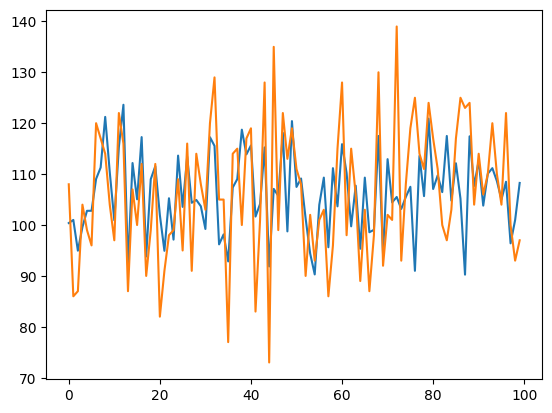

In [23]:
homePreds, w = plot_predictions1(model, X_test, y1_test)

In [24]:
homePreds

,Predictions,Actuals
0,100.387741,108
1,100.997849,86
2,94.963211,87
3,99.605522,104
4,102.790413,99
...,...,...
2559,94.038704,86
2560,99.693230,94
2561,119.489723,113
2562,100.766289,98


In [25]:
model.fit(X_train, y2_train, validation_data=(X_val, y2_val), epochs=1000, callbacks=[earlystopping])


Epoch 1/1000
641/641 [==============================] - 1s 1ms/step - loss: 147.5126 - root_mean_squared_error: 12.1455 - val_loss: 139.5966 - val_root_mean_squared_error: 11.8151
Epoch 2/1000
641/641 [==============================] - 1s 1ms/step - loss: 137.9157 - root_mean_squared_error: 11.7437 - val_loss: 137.7554 - val_root_mean_squared_error: 11.7369
Epoch 3/1000
641/641 [==============================] - 1s 1ms/step - loss: 135.4314 - root_mean_squared_error: 11.6375 - val_loss: 133.3593 - val_root_mean_squared_error: 11.5481
Epoch 4/1000
641/641 [==============================] - 1s 1ms/step - loss: 134.3055 - root_mean_squared_error: 11.5890 - val_loss: 132.7690 - val_root_mean_squared_error: 11.5225
Epoch 5/1000
641/641 [==============================] - 1s 1ms/step - loss: 133.8652 - root_mean_squared_error: 11.5700 - val_loss: 133.6049 - val_root_mean_squared_error: 11.5588
Epoch 6/1000
641/641 [==============================] - 1s 1ms/step - loss: 133.4219 - root_mean_squ

81/81 [==============================] - 0s 650us/step


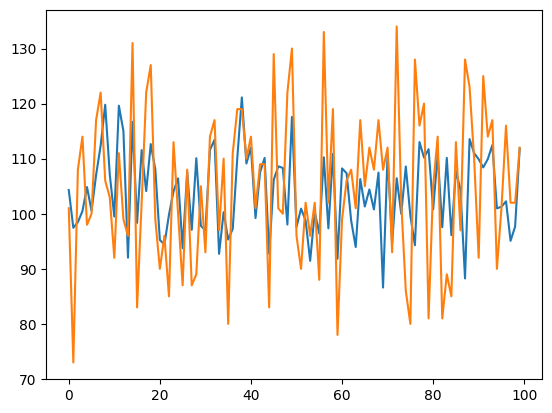

In [26]:
awayPreds, j = plot_predictions1(model, X_test, y2_test)

In [27]:
print(w)
print(j)

130.8045124864947
137.51602770470265


In [29]:
awayPreds

,Predictions,Actuals
0,104.306099,101
1,97.449928,73
2,98.475983,108
3,100.476837,114
4,104.850342,98
...,...,...
2559,92.757217,97
2560,98.170433,96
2561,122.475456,144
2562,96.697159,104


In [33]:
predictWinner = pd.DataFrame({
    'homeScorePred': homePreds['Predictions'],
    'awayScorePred': awayPreds['Predictions'],
    'winner_binary': b_test
})
predictWinner

,homeScorePred,awayScorePred,winner_binary
0,100.387741,104.306099,0
1,100.997849,97.449928,0
2,94.963211,98.475983,1
3,99.605522,100.476837,1
4,102.790413,104.850342,0
...,...,...,...
2559,94.038704,92.757217,1
2560,99.693230,98.170433,1
2561,119.489723,122.475456,1
2562,100.766289,96.697159,1


In [34]:
predictWinner['predicted_winner'] = predictWinner.apply(lambda row: 0 if row['homeScorePred'] >= row['awayScorePred'] else 1, axis=1)
predictWinner

,homeScorePred,awayScorePred,winner_binary,predicted_winner
0,100.387741,104.306099,0,1
1,100.997849,97.449928,0,0
2,94.963211,98.475983,1,1
3,99.605522,100.476837,1,1
4,102.790413,104.850342,0,1
...,...,...,...,...
2559,94.038704,92.757217,1,0
2560,99.693230,98.170433,1,0
2561,119.489723,122.475456,1,1
2562,100.766289,96.697159,1,0


In [36]:
print(accuracy_score(predictWinner['winner_binary'], predictWinner['predicted_winner']))

0.6587363494539782
